In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

plt.style.use('default')
plt.rcParams['savefig.dpi'] = 220
plt.rcParams['figure.figsize'] = (8,8)

Para el caso relativista (ver https://en.wikipedia.org/wiki/Cyclotron)

https://en.wikipedia.org/wiki/Lorentz_force#Relativistic_form_of_the_Lorentz_force

$$\vec{F}= q(\vec{E} + \vec{v}\times\vec{B})$$

$$\dot{\vec{p}} = \frac{d}{dt}(\gamma m_0 \vec{v}) = m_0(\dot{\gamma}\vec{v} + \dot{\vec{v}}\gamma)$$

$$\vec{F}=m_0\{\gamma^3(\vec{\beta}\cdot\vec{a})\vec{\beta} + \gamma\vec{a}\}, \ \beta = \vec{v}/c$$

Sabemos que $\vec{F}\cdot \vec{\beta} = m_0(\vec{\beta}\cdot\vec{a})\gamma^2$ (me cree o hago la talacha), por lo que encontramos la aceleración por medio de:

$$\vec{a} = \frac{1}{m_0\gamma}(\vec{F} - \vec{F}\cdot\vec{\beta})$$

In [2]:
def norm(vec):
    """
    | Calculates the norm of an n-vector 
    """
    vec2 = [vec[ii]**2 for ii in range(len(vec))]
    return np.sum(vec2)**0.5

def mnorm(mat):
    """
    | Calculates norm of matrix
    """
    return np.array([norm(mat[ii]) for ii in range(len(mat))])


def get_verlet_relativistic(t, E, B, q, dist, m, rad, v0):
    
    extra_t = 5e-11 # extra time for particle to run (outside structure)
    
    X = np.zeros((len(t), 3))
    V = np.zeros((len(t), 3))
    V[0] = v0
    KE = np.zeros(len(t))
    emfvec = np.zeros(len(t))
    emfvec[0] = E[0]*dist
    
    for ii in range(len(t) - 1):
        # get kinetic energy
        KE[ii + 1] = get_ke(m, V[ii])
        # x ii + 1 is a dummy now
        X[ii + 1] = X[ii] + 0.5 * dt * V[ii]
        
        acc = accel_relativistic(X[ii], V[ii], E, B, q, m, t[ii])
        V[ii + 1] = V[ii] + dt * acc[0]
        X[ii + 1] = X[ii + 1] + 0.5 * dt * V[ii + 1]
        emfvec[ii + 1] = acc[1,0]
        
        if norm(X[ii + 1]) > rad: 
            #  chop chop chop
            index = ii
            # continue for a bit
            for jj in range(int(extra_t/dt)):
                kk = index + jj
#
                # get kinetic energy
                KE[kk + 1] = get_ke(m, V[kk])
                # x ii + 1 is a dummy now
                X[kk+ 1] = X[kk] + dt * V[kk]
                V[kk+ 1] = V[kk] # a = 0
            
            X = X[:kk + 1]
            V = V[:kk + 1]
            t = t[:kk + 1]
            KE = KE[:kk + 1]
            emfvec = emfvec[:kk + 1]
            break
        
    return X, V, t, KE, emfvec

def get_ke(m,v):
    return 0.5 * m * norm(v)**2

def get_d(axis, radius, dist, color):
    """
    | Obtiene dibujo de las D's para el ciclotrón
    """
    dist = dist/2
    phi = np.linspace(-np.pi/2, np.pi/2, 1000)
    x = radius * np.cos(phi)
    y = radius * np.sin(phi)
    axis.plot((dist,dist), (-radius, radius),'--', color=color)
    axis.plot((-dist,-dist), (-radius, radius), '--', color=color)
    axis.plot(x + dist, y,'--', color = color)
    axis.plot(-(x + dist), y, '--', color = color)

def mass(m0,v):
    """
    | Calculates relativistic mass
    """
    Gamma = (1 - (norm(v)**2 / sc.c**2 ))**-0.5
    return m0 * Gamma

def Force(q, E, v, B):
    """
    | Calculates Lorenz Force
    """
    return q*(E + np.cross(v,B)) 


def accel_relativistic(x, v, E, B, q, m0, time):
    
    m = mass(m0, v)

    w = norm(B) * q / m
    
    # corriente alterna
    AC = np.sign(np.cos(w*time))  

    # inside electric field
    if abs(x[0]) < dist/2:
        return  np.array([
                        (Force(q, E*AC, v, B) - np.dot(Force(q, E*AC, v, B), v) * v/sc.c**2) / m,
                        E*AC])
    
    # outside electric field (E = 0)
    else:
        return np.array([
                        (Force(q,0,v,B) - np.dot(Force(q, 0, v, B), v) * v/sc.c**2)/m,
                        E*AC])

    

In [3]:
# CONSTANTS
dt = 5e-12
T = 1e-6 # upper limit
t = np.arange(0,T,dt)
emf = 5_000 # place emf as 5kV
dist = 5e-3

B0 = np.array([0.,0.,1])
E0 = np.array([emf/dist, 0, 0])

# cyclotron radius
rad = 0.05


m = sc.m_p

q = sc.e

v0 = np.array([0,0,0])

X_R, V_R, TIME_R, KE_R, EMF_R = get_verlet_relativistic(t, E0, B0, q, dist, m, rad, v0)

print(f"Final time: {TIME_R[-1]} [s]")
print(f"Final velocity: {norm(V_R[-1])/sc.c :.3} c [ms^-1]")
print(f"Max velocity: {np.max(mnorm(V_R))/sc.c :.3} c [ms^-1]")

Final time: 6.83715e-07 [s]
Final velocity: 0.0149 c [ms^-1]
Max velocity: 0.0149 c [ms^-1]


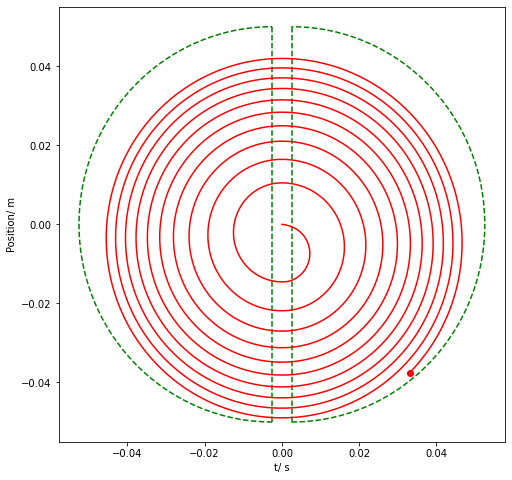

In [4]:
fig, ax1 = plt.subplots(figsize=(8,8))
color = 'red'
get_d(ax1, rad, dist, 'green')
ax1.plot(X_R[:,0], X_R[:,1], color=color)
ax1.plot(X_R[-1,0], X_R[-1, 1], 'o', color=color)
ax1.set_xlabel("t/ s")
ax1.set_ylabel("Position/ m")
plt.show()

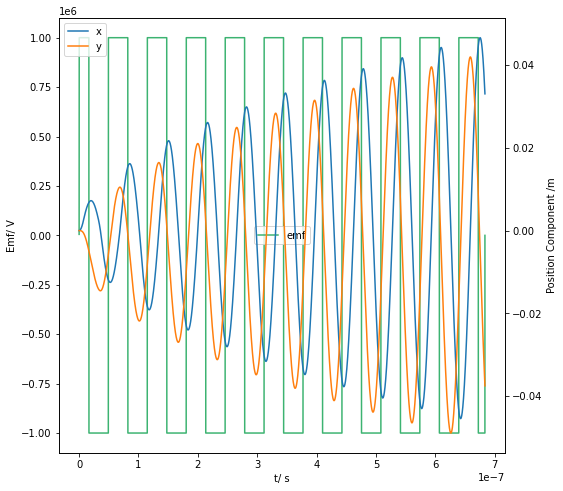

In [5]:
# emf plot with movement of particle

fig, ax4 = plt.subplots(figsize=(8,8))
ax4.plot(TIME_R, EMF_R, label="emf", color="mediumseagreen")
ax_pos = ax4.twinx()
ax_pos.plot(TIME_R, X_R[:,0:2], label=["x", "y"])
ax_pos.set_ylabel("Position Component /m")
ax_pos.legend()
ax4.legend()


# labels and titles
ax4.set_xlabel("t/ s")

ax4.set_ylabel("Emf/ V")

plt.show()